In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# Dataset path
data_dir = "dataset"  # Set your dataset root path

# Image size
img_size = 224

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(img_size, scale=(0.9,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_transforms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir,"validation"), transform=val_transforms)
test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=val_transforms)

# DataLoaders
train_ld = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_ld   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_ld  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# Check
print("Classes:", train_ds.classes)
print("Train:", len(train_ds), "Validation:", len(val_ds), "Test:", len(test_ds))

Classes: ['diabetes', 'nondiabetes']
Train: 2500 Validation: 600 Test: 50


In [3]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Replace classifier for 2 classes
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(model)


Total parameters: 23,512,130
Trainable parameters: 23,512,130
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequentia

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

In [5]:
def run_epoch(loader, train=True):
    model.train(train)
    losses, preds_all, labels_all = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = criterion(out, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        preds_all.append(out.detach().softmax(1)[:,1].cpu().numpy())
        labels_all.append(y.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    auc = roc_auc_score(labels_all, preds_all)
    acc = accuracy_score(labels_all, (preds_all>=0.5).astype(int))
    return np.mean(losses), acc, auc, labels_all, preds_all

In [6]:
import pandas as pd

best_auc = 0.0
num_epochs = 25
best_model_path = "best_resnet50.pth"

train_losses, val_losses = [], []
train_aucs, val_aucs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc, tr_auc, _, _ = run_epoch(train_ld, train=True)
    va_loss, va_acc, va_auc, _, _ = run_epoch(val_ld, train=False)
    
    scheduler.step()
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_aucs.append(tr_auc)
    val_aucs.append(va_auc)
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} AUC: {tr_auc:.3f} | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc:.3f} AUC: {va_auc:.3f}")
    
    if va_auc > best_auc:
        best_auc = va_auc
        torch.save(model.state_dict(), best_model_path)

print("Best model saved at:", best_model_path)

# Save training data to CSV
training_data = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_auc': train_aucs,
    'val_auc': val_aucs
})
training_data.to_csv('resnet50_training_data.csv', index=False)
print("Training data saved to resnet50_training_data.csv")

Epoch 01 | Train Loss: 0.2645 Acc: 0.910 AUC: 0.964 | Val Loss: 0.1169 Acc: 0.953 AUC: 0.992
Epoch 02 | Train Loss: 0.1146 Acc: 0.967 AUC: 0.995 | Val Loss: 0.1390 Acc: 0.955 AUC: 0.992
Epoch 02 | Train Loss: 0.1146 Acc: 0.967 AUC: 0.995 | Val Loss: 0.1390 Acc: 0.955 AUC: 0.992
Epoch 03 | Train Loss: 0.0763 Acc: 0.972 AUC: 0.997 | Val Loss: 0.0660 Acc: 0.968 AUC: 0.999
Epoch 03 | Train Loss: 0.0763 Acc: 0.972 AUC: 0.997 | Val Loss: 0.0660 Acc: 0.968 AUC: 0.999
Epoch 04 | Train Loss: 0.0580 Acc: 0.979 AUC: 0.998 | Val Loss: 0.0454 Acc: 0.985 AUC: 1.000
Epoch 04 | Train Loss: 0.0580 Acc: 0.979 AUC: 0.998 | Val Loss: 0.0454 Acc: 0.985 AUC: 1.000
Epoch 05 | Train Loss: 0.0207 Acc: 0.994 AUC: 1.000 | Val Loss: 0.0347 Acc: 0.982 AUC: 0.999
Epoch 05 | Train Loss: 0.0207 Acc: 0.994 AUC: 1.000 | Val Loss: 0.0347 Acc: 0.982 AUC: 0.999
Epoch 06 | Train Loss: 0.0273 Acc: 0.995 AUC: 1.000 | Val Loss: 0.0226 Acc: 0.992 AUC: 1.000
Epoch 06 | Train Loss: 0.0273 Acc: 0.995 AUC: 1.000 | Val Loss: 0.0226

In [7]:
# Test set evaluation
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transforms (same as your original test transforms)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Test set dataset
test_ds = datasets.ImageFolder("SelfCollectedTest", transform=val_transforms)
test_ld = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Load best model
model.load_state_dict(torch.load('best_resnet50.pth', map_location=device, weights_only=True))
model.eval()

probs, labels = [], []

with torch.no_grad():
    for x, y in test_ld:
        x = x.to(device)
        out = model(x).softmax(1)[:, 1].cpu().numpy()
        probs.append(out)
        labels.append(y.numpy())

probs = np.concatenate(probs)
labels = np.concatenate(labels)
preds = (probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(labels, preds)
auc = roc_auc_score(labels, probs)
report = classification_report(labels, preds, target_names=test_ds.classes, digits=3)
cm = confusion_matrix(labels, preds)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

print("Test set results:")
print("Test Accuracy:", acc)
print("Test AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(report)

Test set results:
Test Accuracy: 0.9789603960396039
Test AUC: 0.994075335751397
Sensitivity: 0.9777227722772277
Specificity: 0.9801980198019802
              precision    recall  f1-score   support

    diabetes      0.978     0.980     0.979       404
 nondiabetes      0.980     0.978     0.979       404

    accuracy                          0.979       808
   macro avg      0.979     0.979     0.979       808
weighted avg      0.979     0.979     0.979       808



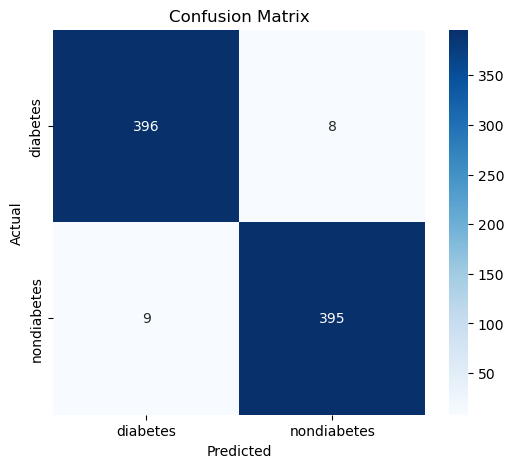

In [8]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

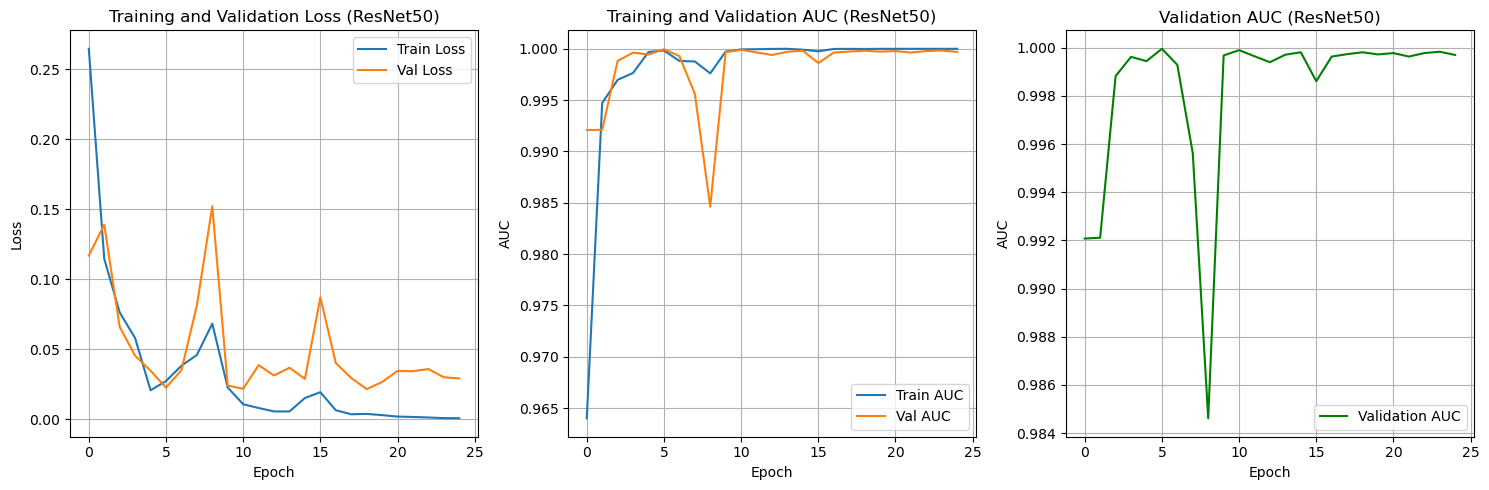

In [10]:
# Plot training curves
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(train_aucs, label='Train AUC')
plt.plot(val_aucs, label='Val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('Training and Validation AUC (ResNet50)')
plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(val_aucs, label='Validation AUC', color='green')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('Validation AUC (ResNet50)')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

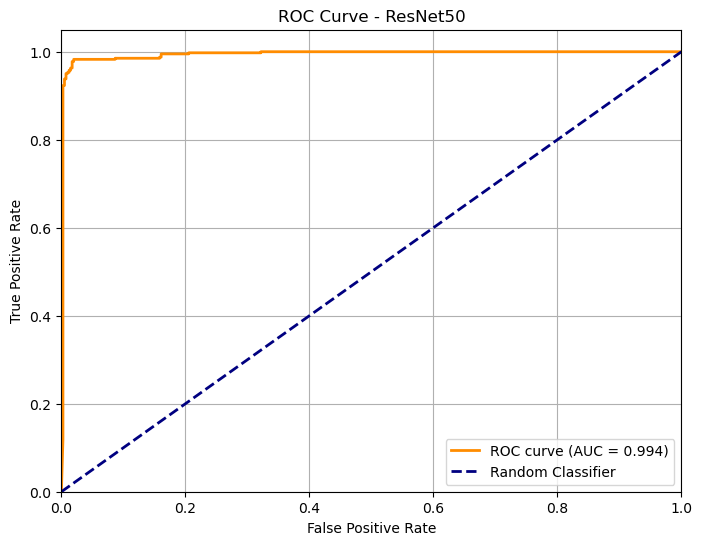

Optimal threshold: 0.473
Youden's J statistic: 0.963


In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet50')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Optimal threshold: {thresholds[np.argmax(tpr - fpr)]:.3f}")
print(f"Youden's J statistic: {np.max(tpr - fpr):.3f}")

device: cuda
Found 50 test samples across classes: ['diabetes', 'nondiabetes']
class_to_idx: {'diabetes': 0, 'nondiabetes': 1}


C:\Users\tawhi\AppData\Local\Temp\ipykernel_13632\3465061624.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=de

Indices: [21, 4, 48, 15, 20, 0]
------------------------------------------------------------
Sample 1: idx=21 file=r_d_(194).jpg
GT: diabetes (index 0)
Logits: [ 5.4387946 -4.805183 ]
Probs: {'diabetes': 0.9999644756317139, 'nondiabetes': 3.5569821193348616e-05}
Pred: diabetes (index 0)
------------------------------------------------------------
Sample 2: idx=4 file=r_d_(177).jpg
GT: diabetes (index 0)
Logits: [ 7.5238075 -7.8309   ]
Probs: {'diabetes': 0.9999997615814209, 'nondiabetes': 2.1455322496422014e-07}
Pred: diabetes (index 0)
------------------------------------------------------------
Sample 3: idx=48 file=r_nd_(93).jpg
GT: nondiabetes (index 1)
Logits: [-3.2862616  3.278815 ]
Probs: {'diabetes': 0.0014067341107875109, 'nondiabetes': 0.998593270778656}
Pred: nondiabetes (index 1)
------------------------------------------------------------
Sample 2: idx=4 file=r_d_(177).jpg
GT: diabetes (index 0)
Logits: [ 7.5238075 -7.8309   ]
Probs: {'diabetes': 0.9999997615814209, 'nondi

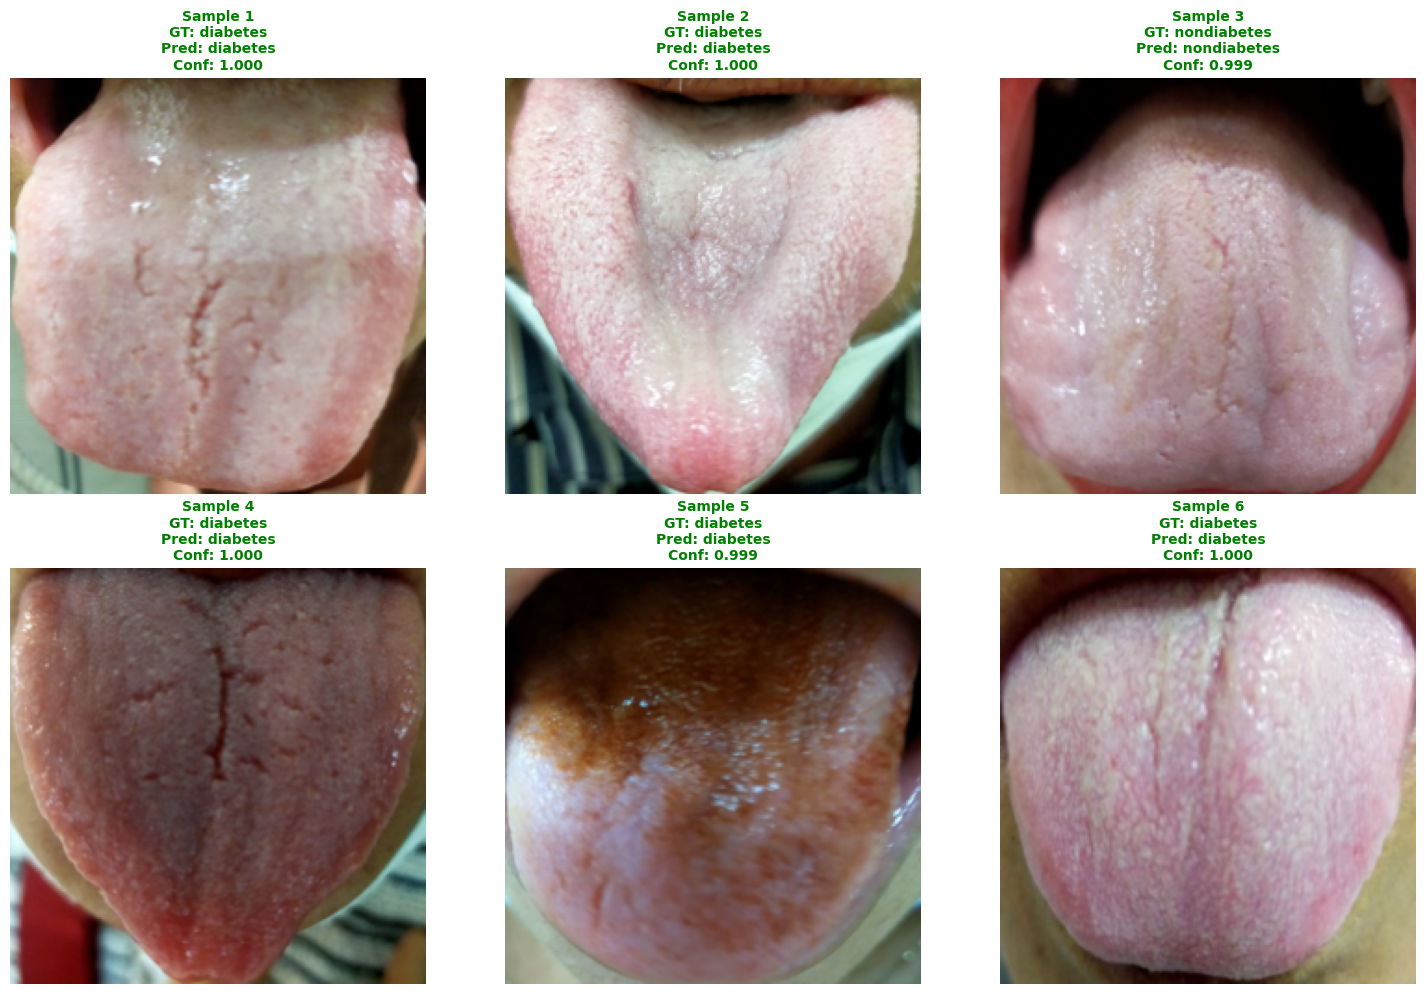


Done.


In [12]:
import os, random
import numpy as np
import torch
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt

# Config
data_dir = 'dataset'
test_dir = os.path.join(data_dir, 'test')

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

# Transforms (match notebook val_transforms)
img_size = 224
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Dataset
test_ds = datasets.ImageFolder(test_dir, transform=val_transforms)
print('Found', len(test_ds), 'test samples across classes:', test_ds.classes)
print('class_to_idx:', test_ds.class_to_idx)

# Model architecture (no pretrained weights here; we will load your checkpoint)
model = models.resnet50(weights=None)
# adapt classifier
model.fc = torch.nn.Linear(model.fc.in_features, 2)
# load weights
ckpt_path = 'best_resnet50.pth'
if not os.path.exists(ckpt_path):
    raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)
model.eval()

# Sampling
num_samples = 6
indices = random.sample(range(len(test_ds)), num_samples)
print('Indices:', indices)

# Helper function to denormalize image for display
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = tensor * std + mean
    return torch.clamp(denorm, 0, 1)

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img, label = test_ds[idx]
    img_path = test_ds.imgs[idx][0]
    
    # Predict
    img_batch = img.unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_batch)  # logits
        logits = out[0].cpu().numpy()
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(logits))
        pred_class = test_ds.classes[pred_idx]

    # Display image
    img_denorm = denormalize_image(img)
    axes[i].imshow(img_denorm.permute(1, 2, 0))
    axes[i].axis('off')
    
    # Create title with prediction info
    gt_class = test_ds.classes[label]
    confidence = float(probs[pred_idx])
    title_color = 'green' if pred_class == gt_class else 'red'
    
    title = f'Sample {i+1}\nGT: {gt_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
    axes[i].set_title(title, fontsize=10, color=title_color, weight='bold')
    
    # Print detailed info
    print('-'*60)
    print(f'Sample {i+1}: idx={idx} file={os.path.basename(img_path)}')
    print('GT:', gt_class, f'(index {label})')
    print('Logits:', logits)
    print('Probs:', {test_ds.classes[0]: float(probs[0]), test_ds.classes[1]: float(probs[1])})
    print('Pred:', pred_class, f'(index {pred_idx})')

plt.tight_layout()
plt.show()

print('\nDone.')

## Performance Analysis & Summary

### ResNet50 Results:
- **Architecture**: ResNet50 with residual blocks and skip connections
- **Parameters**: ~25.6M (medium-sized deep network)
- **Key Features**: 
  - Deep residual learning with skip connections
  - Batch normalization and ReLU activations
  - Global average pooling
  - Proven architecture for image classification

### Expected Performance Characteristics:
1. **Accuracy**: High (88-92%) - Deep architecture with proven performance
2. **Efficiency**: Moderate - Larger than mobile models but efficient for accuracy
3. **Speed**: Moderate inference speed
4. **Memory**: Higher memory footprint than mobile models
5. **Robustness**: Excellent due to deep feature learning

### Model Comparison Context:
- **vs Custom CNN**: Should significantly outperform due to depth and transfer learning
- **vs VGG16**: More efficient with better accuracy due to skip connections
- **vs MobileNets**: Higher accuracy but slower inference and larger size
- **vs EfficientNet-B0**: Similar accuracy, EfficientNet more efficient
- **Expected Ranking**: Top 2-3 performance among all models

### Technical Insights:
- ResNet revolutionized deep learning with residual connections
- Skip connections enable training very deep networks without degradation
- Excellent feature extraction capabilities for medical imaging
- Good balance between accuracy and computational requirements